In [1]:
import os
import numpy as np
import pandas as pd
from pathlib import Path
import cv2
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms

import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, HTML

from sklearn.metrics import (
    accuracy_score, 
    precision_score, 
    recall_score, 
    f1_score,
    confusion_matrix,
    classification_report
)

import warnings
warnings.filterwarnings('ignore')

SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)

DATA_DIR = Path('./data')
ADL_DIR = DATA_DIR / 'adl'
FALL_DIR = DATA_DIR / 'fall'
IMG_SIZE = 224
BATCH_SIZE = 8
NUM_FRAMES = 40
LEARNING_RATE = 1e-4
EPOCHS = 10

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cuda


In [2]:
def explore_sequences(base_dir, label_name):
    sequences = []
    
    for sequence_dir in sorted(base_dir.iterdir()):
        if sequence_dir.is_dir():
            frames = sorted(list(sequence_dir.glob('*.png')))
            
            if len(frames) > 0:
                sequences.append({
                    'sequence_name': sequence_dir.name,
                    'path': sequence_dir,
                    'num_frames': len(frames),
                    'label': label_name
                })
    
    return sequences

fall_sequences = explore_sequences(FALL_DIR, 'fall')
adl_sequences = explore_sequences(ADL_DIR, 'adl')

In [3]:
train_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [4]:
class FallDetectionDataset(Dataset):
    def __init__(self, sequences, num_frames=40, transform=None):
        self.sequences = sequences
        self.num_frames = num_frames
        self.transform = transform
        self.label_map = {'fall': 1, 'adl': 0}

    def __len__(self):
        return len(self.sequences)
    
    def _sample_frames(self, frame_paths):
        total_frames = len(frame_paths)
        
        if total_frames <= self.num_frames:
            indices = list(range(total_frames))
            indices += [total_frames - 1] * (self.num_frames - total_frames)
        else:
            indices = np.linspace(0, total_frames - 1, self.num_frames, dtype=int)
        
        return [frame_paths[i] for i in indices]

    def __getitem__(self, idx):
        seq_info = self.sequences[idx]
        all_frames = sorted(list(seq_info['path'].glob('*.png')))
        sampled_frames = self._sample_frames(all_frames)
        
        frames_tensors = []
        for frame_path in sampled_frames:
            img = Image.open(frame_path).convert('RGB')
            
            if self.transform:
                img = self.transform(img)
            
            frames_tensors.append(img)
        
        frames = torch.stack(frames_tensors)
        label = self.label_map[seq_info['label']]
        
        return frames, label

In [5]:
from sklearn.model_selection import train_test_split

all_sequences = fall_sequences + adl_sequences

train_val_sequences, test_sequences = train_test_split(
    all_sequences,
    test_size=0.2,
    random_state=SEED,
    stratify=[seq['label'] for seq in all_sequences]
)

train_sequences, val_sequences = train_test_split(
    train_val_sequences,
    test_size=0.125,
    random_state=SEED,
    stratify=[seq['label'] for seq in train_val_sequences]
)

train_dataset = FallDetectionDataset(
    train_sequences, 
    num_frames=NUM_FRAMES, 
    transform=train_transform  
)

val_dataset = FallDetectionDataset(
    val_sequences, 
    num_frames=NUM_FRAMES, 
    transform=test_transform  
)

test_dataset = FallDetectionDataset(
    test_sequences, 
    num_frames=NUM_FRAMES, 
    transform=test_transform 
)

train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=2,
    pin_memory=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=2,
    pin_memory=True
)

test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=2,
    pin_memory=True
)

In [6]:
import torch.nn as nn
from torchvision import models

class FallDetectionModel(nn.Module):
    def __init__(self, num_classes=2, lstm_hidden=256, lstm_layers=2, dropout=0.5):
        super(FallDetectionModel, self).__init__()
        
        resnet = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V2)
        self.feature_extractor = nn.Sequential(*list(resnet.children())[:-1])
        
        for param in self.feature_extractor.parameters():
            param.requires_grad = False
        
        self.feature_dim = 2048
        
        self.lstm = nn.LSTM(
            input_size=self.feature_dim,
            hidden_size=lstm_hidden,
            num_layers=lstm_layers,
            batch_first=True,
            dropout=dropout if lstm_layers > 1 else 0
        )
        
        self.classifier = nn.Sequential(
            nn.Dropout(dropout),
            nn.Linear(lstm_hidden, 128),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(128, num_classes)
        )
    
    def forward(self, x):
        batch_size, num_frames, c, h, w = x.shape
        
        x = x.view(batch_size * num_frames, c, h, w)
        x = self.feature_extractor(x)
        x = x.squeeze(-1).squeeze(-1)
        x = x.view(batch_size, num_frames, self.feature_dim)
        
        lstm_out, (h_n, c_n) = self.lstm(x)
        x = lstm_out[:, -1, :]
        
        logits = self.classifier(x)
        
        return logits


In [7]:
model = FallDetectionModel(
    num_classes=2,
    lstm_hidden=256,
    lstm_layers=2,
    dropout=0.5
)

model = model.to(device)

def count_parameters(model):
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    return total_params, trainable_params

total, trainable = count_parameters(model)

In [8]:

test_batch_frames, test_batch_labels = next(iter(train_loader))

print(f"Input shape: {test_batch_frames.shape}")

test_batch_frames = test_batch_frames.to(device)
test_batch_labels = test_batch_labels.to(device)

model.eval()
with torch.no_grad():
    logits = model(test_batch_frames)

print(f"Output shape: {logits.shape}")
print(f"Logits:\n{logits}")

probs = torch.softmax(logits, dim=1)
print(f"\nPrawdopodobieństwa:\n{probs}")

predictions = torch.argmax(logits, dim=1)
print(f"\nPredykcje: {predictions}")
print(f"Prawdziwe: {test_batch_labels}")


Input shape: torch.Size([8, 40, 3, 224, 224])
Output shape: torch.Size([8, 2])
Logits:
tensor([[0.0664, 0.0741],
        [0.0706, 0.0859],
        [0.0401, 0.0927],
        [0.0505, 0.0589],
        [0.0498, 0.0757],
        [0.0631, 0.0709],
        [0.0654, 0.0626],
        [0.0681, 0.0737]], device='cuda:0')

Prawdopodobieństwa:
tensor([[0.4981, 0.5019],
        [0.4962, 0.5038],
        [0.4869, 0.5131],
        [0.4979, 0.5021],
        [0.4935, 0.5065],
        [0.4980, 0.5020],
        [0.5007, 0.4993],
        [0.4986, 0.5014]], device='cuda:0')

Predykcje: tensor([1, 1, 1, 1, 1, 1, 0, 1], device='cuda:0')
Prawdziwe: tensor([1, 1, 0, 0, 0, 1, 0, 1], device='cuda:0')


In [9]:
criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(
    model.parameters(),
    lr=LEARNING_RATE,
    weight_decay=1e-5
)

scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min',
    factor=0.5,
    patience=3,
    verbose=True,    
    min_lr=1e-7        
)

In [10]:
def train_one_epoch(model, dataloader, criterion, optimizer, device):
    model.train() 
    
    running_loss = 0.0
    correct = 0
    total = 0
    
    for batch_frames, batch_labels in dataloader:
        batch_frames = batch_frames.to(device)
        batch_labels = batch_labels.to(device)
        
        optimizer.zero_grad()
        logits = model(batch_frames)
        loss = criterion(logits, batch_labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * batch_frames.size(0)
        predictions = torch.argmax(logits, dim=1)
        correct += (predictions == batch_labels).sum().item()
        total += batch_labels.size(0)
    
    avg_loss = running_loss / total
    avg_acc = correct / total
    
    return avg_loss, avg_acc


def validate(model, dataloader, criterion, device):
    model.eval()
    
    running_loss = 0.0
    correct = 0
    total = 0
    
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for batch_frames, batch_labels in dataloader:
            batch_frames = batch_frames.to(device)
            batch_labels = batch_labels.to(device)
            
            logits = model(batch_frames)
            loss = criterion(logits, batch_labels)
            
            running_loss += loss.item() * batch_frames.size(0)
            predictions = torch.argmax(logits, dim=1)
            correct += (predictions == batch_labels).sum().item()
            total += batch_labels.size(0)
            
            all_preds.extend(predictions.cpu().numpy())
            all_labels.extend(batch_labels.cpu().numpy())
    
    avg_loss = running_loss / total
    avg_acc = correct / total
    
    return avg_loss, avg_acc, all_preds, all_labels

In [11]:
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, 
                num_epochs, device, patience=5, save_model=True, model_path='best_model.pth'):
    history = {
        'train_loss': [],
        'train_acc': [],
        'val_loss': [],
        'val_acc': [],
        'lr': []
    }
    
    best_val_loss = float('inf')
    epochs_without_improvement = 0
    best_model_state = None

    for epoch in range(num_epochs):
        print(f"Epoka {epoch+1}/{num_epochs}")
        
        train_loss, train_acc = train_one_epoch(
            model, train_loader, criterion, optimizer, device
        )

        val_loss, val_acc, _, _ = validate(
            model, val_loader, criterion, device
        )
        
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        history['lr'].append(optimizer.param_groups[0]['lr'])

        print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")
        print(f"Val Loss:   {val_loss:.4f} | Val Acc:   {val_acc:.4f}")
        print(f"LR:         {optimizer.param_groups[0]['lr']:.6f}")
        
        scheduler.step(val_loss)
        
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            epochs_without_improvement = 0
            best_model_state = model.state_dict().copy()
            
            if save_model:
                torch.save({
                    'epoch': epoch,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'val_loss': val_loss,
                    'val_acc': val_acc,
                }, model_path)
            
        else:
            epochs_without_improvement += 1
            
            if epochs_without_improvement >= patience:
                print(f"robimy early stopping po {epoch+1} epokach")
                break
    
    if best_model_state is not None:
        model.load_state_dict(best_model_state)
    
    return history

In [12]:
def run_single_experiment(train_sequences, val_sequences, device, save_model=False):
    train_dataset = FallDetectionDataset(
        train_sequences,
        num_frames=NUM_FRAMES,
        transform=train_transform
    )

    val_dataset = FallDetectionDataset(
        val_sequences,
        num_frames=NUM_FRAMES,
        transform=test_transform
    )

    train_loader = DataLoader(
        train_dataset,
        batch_size=BATCH_SIZE,
        shuffle=True,
        num_workers=2,
        pin_memory=True
    )

    val_loader = DataLoader(
        val_dataset,
        batch_size=BATCH_SIZE,
        shuffle=False,
        num_workers=2,
        pin_memory=True
    )

    model = FallDetectionModel().to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-5)

    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer,
        mode='min',
        factor=0.5,
        patience=3,
        min_lr=1e-7
    )

    history = train_model(
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        criterion=criterion,
        optimizer=optimizer,
        scheduler=scheduler,
        num_epochs=EPOCHS,
        device=device,
        patience=5,
        save_model=save_model
    )

    val_loss, val_acc, preds, labels = validate(
        model, val_loader, criterion, device
    )

    return val_loss, val_acc, preds, labels

In [ ]:
from sklearn.model_selection import LeaveOneOut

loo = LeaveOneOut()


all_loo_preds = []      
all_loo_labels = []     
loo_accuracies = []
loo_results = []  

for fold, (train_idx, val_idx) in enumerate(loo.split(all_sequences)):
    train_sequences = [all_sequences[i] for i in train_idx]
    val_sequences = [all_sequences[i] for i in val_idx]
 
    test_sample = all_sequences[val_idx[0]]

    _, val_acc, preds, labels_true = run_single_experiment(
        train_sequences, val_sequences, device, save_model=False
    )

    all_loo_preds.extend(preds)
    all_loo_labels.extend(labels_true)
    
    loo_accuracies.append(val_acc)

    loo_results.append({
        'fold': fold,
        'index': val_idx[0],
        'sequence_name': test_sample['sequence_name'],
        'true_label': labels_true[0],
        'predicted_label': preds[0],
        'correct': labels_true[0] == preds[0],
        'label_name': test_sample['label']
    })
    

global_accuracy = accuracy_score(all_loo_labels, all_loo_preds)
global_f1 = f1_score(all_loo_labels, all_loo_preds)

print(f"\nGlobal Accuracy:  {global_accuracy:.4f} ")
print(f"Global F1-Score:  {global_f1:.4f} ")



Epoka 1/10
Train Loss: 0.6923 | Train Acc: 0.4493
Val Loss:   0.7068 | Val Acc:   0.0000
LR:         0.000100
Epoka 2/10
Train Loss: 0.6717 | Train Acc: 0.7101
Val Loss:   0.6942 | Val Acc:   0.0000
LR:         0.000100
Epoka 3/10
Train Loss: 0.6468 | Train Acc: 0.8261
Val Loss:   0.6755 | Val Acc:   1.0000
LR:         0.000100
Epoka 4/10
Train Loss: 0.6120 | Train Acc: 0.7826
Val Loss:   0.6389 | Val Acc:   1.0000
LR:         0.000100
Epoka 5/10
Train Loss: 0.5145 | Train Acc: 0.9565
Val Loss:   0.5701 | Val Acc:   1.0000
LR:         0.000100
Epoka 6/10
Train Loss: 0.3756 | Train Acc: 0.9565
Val Loss:   0.4836 | Val Acc:   1.0000
LR:         0.000100
Epoka 7/10
Train Loss: 0.2539 | Train Acc: 1.0000
Val Loss:   0.3907 | Val Acc:   1.0000
LR:         0.000100
Epoka 8/10
Train Loss: 0.2239 | Train Acc: 0.9855
Val Loss:   0.2838 | Val Acc:   1.0000
LR:         0.000100
Epoka 9/10
Train Loss: 0.1386 | Train Acc: 0.9855
Val Loss:   0.1816 | Val Acc:   1.0000
LR:         0.000100
Epoka 10/1

In [ ]:
results_df = pd.DataFrame(loo_results)

misclassified = [r for r in loo_results if not r['correct']]
print(f"\nLiczba błędnych predykcji: {len(misclassified)}/{len(all_sequences)}")

if misclassified:
    print("\nBłędnie sklasyfikowane próbki:")
    print("-" * 80)
    for item in misclassified:
        true_name = 'FALL' if item['true_label'] == 1 else 'ADL'
        pred_name = 'FALL' if item['predicted_label'] == 1 else 'ADL'
        print(f"Fold {item['fold']:3d} | Indeks: {item['index']:3d} | "
              f"Sekwencja: {item['sequence_name']:25s} | "
              f"Prawda: {true_name:4s} | Predykcja: {pred_name:4s}")


print("Statystyki błędnych predykcji:")
print(f"Całkowita liczba próbek: {len(results_df)}")
print(f"Poprawne predykcje: {results_df['correct'].sum()}")
print(f"Błędne predykcje: {(~results_df['correct']).sum()}")
print(f"Accuracy: {results_df['correct'].mean():.4f}")

misclassified_df = results_df[~results_df['correct']]

if len(misclassified_df) > 0:
    print("\n--- Analiza błędnych predykcji ---")
    print("\nFałszywe alarmy (ADL sklasyfikowany jako FALL):")
    false_positives = misclassified_df[(misclassified_df['true_label'] == 0) & (misclassified_df['predicted_label'] == 1)]
    for _, row in false_positives.iterrows():
        print(f"  Indeks {row['index']:3d}: {row['sequence_name']}")
    
    print(f"\nPominięte upadki (FALL sklasyfikowany jako ADL):")
    false_negatives = misclassified_df[(misclassified_df['true_label'] == 1) & (misclassified_df['predicted_label'] == 0)]
    for _, row in false_negatives.iterrows():
        print(f"  Indeks {row['index']:3d}: {row['sequence_name']}")
    
    # zapiszemy do csv zeby miec w razie w
    results_df.to_csv('loo_results.csv', index=False)
    print(f"\nWyniki zapisane do 'loo_results.csv'")



Liczba błędnych predykcji: 1/70

Błędnie sklasyfikowane próbki:
--------------------------------------------------------------------------------
Fold  61 | Indeks:  61 | Sekwencja: adl-32-cam0-rgb           | Prawda: ADL  | Predykcja: FALL
Statystyki błędnych predykcji:
Całkowita liczba próbek: 70
Poprawne predykcje: 69
Błędne predykcje: 1
Accuracy: 0.9857

--- Analiza błędnych predykcji ---

Fałszywe alarmy (ADL sklasyfikowany jako FALL):
  Indeks  61: adl-32-cam0-rgb

Pominięte upadki (FALL sklasyfikowany jako ADL):

Wyniki zapisane do 'loo_results.csv'


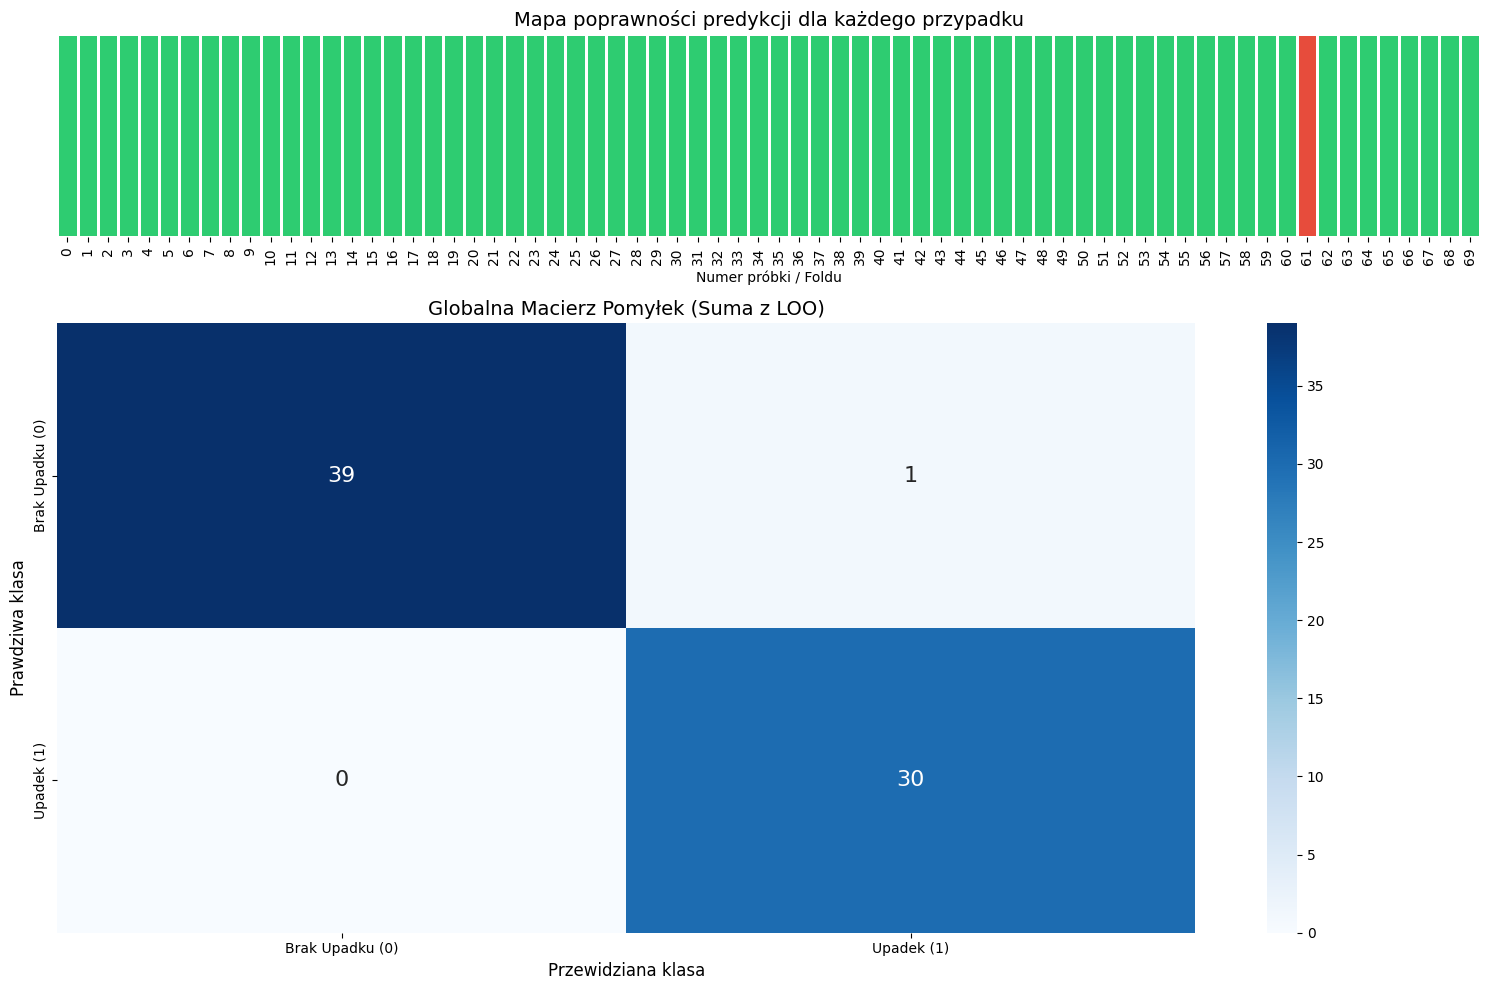

              precision    recall  f1-score   support

 Brak Upadku       1.00      0.97      0.99        40
      Upadek       0.97      1.00      0.98        30

    accuracy                           0.99        70
   macro avg       0.98      0.99      0.99        70
weighted avg       0.99      0.99      0.99        70



In [15]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

results_array = np.array(loo_accuracies).reshape(1, -1)

fig, axes = plt.subplots(2, 1, figsize=(15, 10), gridspec_kw={'height_ratios': [1, 3]})

sns.heatmap(results_array, annot=False, cbar=False, cmap=['#e74c3c', '#2ecc71'], 
            linewidths=1, linecolor='white', ax=axes[0])
axes[0].set_title('Mapa poprawności predykcji dla każdego przypadku', fontsize=14)
axes[0].set_xlabel('Numer próbki / Foldu')
axes[0].set_yticks([])


cm = confusion_matrix(all_loo_labels, all_loo_preds)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[1], annot_kws={"size": 16})
axes[1].set_title('Globalna Macierz Pomyłek (Suma z LOO)', fontsize=14)
axes[1].set_xlabel('Przewidziana klasa', fontsize=12)
axes[1].set_ylabel('Prawdziwa klasa', fontsize=12)
axes[1].set_xticklabels(['Brak Upadku (0)', 'Upadek (1)'])
axes[1].set_yticklabels(['Brak Upadku (0)', 'Upadek (1)'])

plt.tight_layout()
plt.show()

from sklearn.metrics import classification_report
print(classification_report(all_loo_labels, all_loo_preds, target_names=['Brak Upadku', 'Upadek']))

### Trenowanie finalnego modelu

Po przeprowadzeniu LOO cross-validation dla oceny wydajności, teraz trenujemy finalny model na pełnym zbiorze treningowym (train + val), który będzie użyty do testowania.

In [ ]:

final_train_sequences = train_sequences + val_sequences

final_train_dataset = FallDetectionDataset(
    final_train_sequences,
    num_frames=NUM_FRAMES,
    transform=train_transform
)

final_val_dataset = FallDetectionDataset(
    test_sequences,
    num_frames=NUM_FRAMES,
    transform=test_transform
)

final_train_loader = DataLoader(
    final_train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=2,
    pin_memory=True
)

final_val_loader = DataLoader(
    final_val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=2,
    pin_memory=True
)

final_model = FallDetectionModel().to(device)

final_criterion = nn.CrossEntropyLoss()
final_optimizer = optim.Adam(final_model.parameters(), lr=LEARNING_RATE, weight_decay=1e-5)

final_scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    final_optimizer,
    mode='min',
    factor=0.5,
    patience=3,
    min_lr=1e-7
)

final_history = train_model(
    model=final_model,
    train_loader=final_train_loader,
    val_loader=final_val_loader,
    criterion=final_criterion,
    optimizer=final_optimizer,
    scheduler=final_scheduler,
    num_epochs=EPOCHS,
    device=device,
    patience=5,
    save_model=True,
    model_path='best_model.pth'
)

print("\n zapisano model jako 'best_model.pth'")

Epoka 1/10
Train Loss: 0.6985 | Train Acc: 0.4429
Val Loss:   0.6907 | Val Acc:   0.4286
LR:         0.000100
Epoka 2/10
Train Loss: 0.6826 | Train Acc: 0.5143
Val Loss:   0.6698 | Val Acc:   0.7143
LR:         0.000100
Epoka 3/10
Train Loss: 0.6727 | Train Acc: 0.6429
Val Loss:   0.6398 | Val Acc:   1.0000
LR:         0.000100
Epoka 4/10
Train Loss: 0.6322 | Train Acc: 0.9286
Val Loss:   0.5880 | Val Acc:   1.0000
LR:         0.000100
Epoka 5/10
Train Loss: 0.5559 | Train Acc: 1.0000
Val Loss:   0.4738 | Val Acc:   1.0000
LR:         0.000100
Epoka 6/10
Train Loss: 0.4239 | Train Acc: 1.0000
Val Loss:   0.3005 | Val Acc:   1.0000
LR:         0.000100
Epoka 7/10
Train Loss: 0.2560 | Train Acc: 1.0000
Val Loss:   0.1512 | Val Acc:   1.0000
LR:         0.000100
Epoka 8/10
Train Loss: 0.1375 | Train Acc: 1.0000
Val Loss:   0.0710 | Val Acc:   1.0000
LR:         0.000100
Epoka 9/10
Train Loss: 0.1171 | Train Acc: 0.9714
Val Loss:   0.0398 | Val Acc:   1.0000
LR:         0.000100
Epoka 10/1

In [17]:
print("zaladowanie najleposzego modelu i wyniki na zbiorze testowym")

checkpoint = torch.load('best_model.pth')
final_model.load_state_dict(checkpoint['model_state_dict'])

test_loss, test_acc, test_preds, test_labels = validate(
    final_model, test_loader, criterion, device
)

print(f"\nWyniki na zbiorze testowym:")
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f} ({test_acc*100:.2f}%)")

zaladowanie najleposzego modelu i wyniki na zbiorze testowym

Wyniki na zbiorze testowym:
Test Loss: 0.0243
Test Accuracy: 1.0000 (100.00%)


In [18]:
from sklearn.metrics import classification_report, confusion_matrix

class_names = ['ADL', 'FALL']

report = classification_report(
    test_labels, 
    test_preds, 
    target_names=class_names,
    digits=4
)
print(report)

              precision    recall  f1-score   support

         ADL     1.0000    1.0000    1.0000         8
        FALL     1.0000    1.0000    1.0000         6

    accuracy                         1.0000        14
   macro avg     1.0000    1.0000    1.0000        14
weighted avg     1.0000    1.0000    1.0000        14

